In [1]:
%%html
<style>table {float: left;}</style>

## 量子回路(JSON形式)における量子素子間の結合制約

### 結合制約に対する適合性の検査

&ensp;**関数**<br>
&emsp;`test_restriction_with_json(json_str: str, qbit_graph: Graph) -> List[int]`<br>
&ensp;**ソースコード**<br>
&emsp;`qulacs/python/extra/adapt_to_connection_restriction_with_json.py`

結合制約(`qbit_graph`パラメータ)を参照して、回路を構成する各ゲートの control qubit とtarget qubit が結合可能かどうかを検査する。

control qubit を持たないゲート(H, X など)は検査対象外とするが、SWAP ゲート(control qubit 0 個、target qubit 2 個)は検査対象とする。

結合不可の場合は制約条件に不適合であると判定して、全ての不適合ゲートのインデックス(量子回路上での順番)をリストにして返す。

| parameter | description |
|    :-:    |     :-:     |
| json_str   | JSON形式で定義された量子回路 |
| qbit_graph | 結合制約を表現するグラフ構造 |

<br><br><br><br>

### 結合制約に適合させるための SWAP ゲートの配置

&ensp;**関数**<br>
&emsp;`adapt_to_connection_restriction_with_json(json_str: str, qbit_graph: Graph) -> str`<br>
&ensp;**ソースコード**<br>
&emsp;`qulacs/python/extra/adapt_to_connection_restriction_with_json.py`

`test_restriction_with_json()` の実行で不適合と判定されたゲートに対して、制約条件に適合させるための SWAP ゲートを配置する。

具体的には不適合ゲートのターゲット qubit を、制約条件に適合する位置にある qubit と交換する。交換処理に使用する SWAP ゲートにも制約条件が適用されるため、場合によっては複数回の交換処理が発生する。この交換処理の回数を最小化するためにダイクストラ法(Dijkstra's shortest path algorithm)を利用している。

交換した qubit は元の位置に戻す必要があるので、ゲートを作用させた後に SWAP ゲートを逆順序に配置している。

| parameter | description |
|    :-:    |     :-:     |
| json_str   | JSON形式で定義された量子回路 |
| qbit_graph | 結合制約を表現するグラフ構造 |

### 実行例

In [2]:
from qulacs import Graph, QuantumCircuit

# 検査対象の量子回路を構築
circuit = QuantumCircuit(6)
circuit.add_X_gate(0)
circuit.add_CNOT_gate(0, 1)
circuit.add_CNOT_gate(1, 2)
circuit.add_CNOT_gate(2, 3)

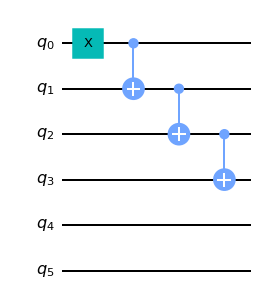

In [3]:
# 回路図を表示(qiskit)
circuit.figure().draw('mpl')

Populating the interactive namespace from numpy and matplotlib


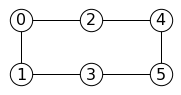

In [4]:
# 量子ビット間の結合を定義
graph = {
  0: [1, 2],
  1: [0, 3],
  2: [0, 4],
  3: [1, 5],
  4: [2, 5],
  5: [3, 4]
}

# 結合状態(グラフ)を可視化
import networkx as nx

G = nx.Graph()
G.add_nodes_from(range(6))
G.add_edges_from(
    sum([[(kq, q) for q in vq] for kq, vq in graph.items()], []))
pos = {
  0: (-1, 1), 1: (-1, -1), 2: (0, 1), 3: (0, -1), 4: (1, 1), 5: (1, -1),
}

%pylab inline --no-import-all
pylab.rcParams['figure.figsize'] = (3, 1.5)
pylab.rcParams['axes.xmargin'] = 0.1
pylab.rcParams['axes.ymargin'] = 0.25
pylab.rcParams['axes.edgecolor'] = 'w'

nx.draw_networkx(G, pos, font_size=16)
nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color='w')
nodes.set_edgecolor('black')

In [5]:
from qulacs import qasm_to_json, json_to_qasm
from qulacs import test_restriction_with_json, adapt_to_connection_restriction_with_json

# qulacs の内部表現 -> QASM -> JSON format
json_str = qasm_to_json(circuit.to_qasm())
print(json_str)

{
  "qasm_version": "2.0",
  "include_files": [
    "qelib1.inc"
  ],
  "qubits": [
    {
      "name": "q",
      "num": 6
    }
  ],
  "classical_registers": [],
  "quantum_gates": [
    {
      "name": "x",
      "param": null,
      "control": [],
      "target": [
        {
          "name": "q",
          "idx": 0
        }
      ]
    },
    {
      "name": "cx",
      "param": null,
      "control": [
        {
          "name": "q",
          "idx": 0
        }
      ],
      "target": [
        {
          "name": "q",
          "idx": 1
        }
      ]
    },
    {
      "name": "cx",
      "param": null,
      "control": [
        {
          "name": "q",
          "idx": 1
        }
      ],
      "target": [
        {
          "name": "q",
          "idx": 2
        }
      ]
    },
    {
      "name": "cx",
      "param": null,
      "control": [
        {
          "name": "q",
          "idx": 2
        }
      ],
      "target": [
        {
          "name": "q",
 

In [6]:
# 回路の結合制約をチェック
rc = test_restriction_with_json(json_str, graph)
if len(rc) == 0:
  print("結合制約に適合している")
else:
  print(f"結合制約に適合していないゲートの番号(index): {rc}")

結合制約に適合していないゲートの番号(index): [2, 3]


In [7]:
# 不適合ゲートの両側に SWAP ゲートを配置
fixed_circuit = adapt_to_connection_restriction_with_json(json_str, graph)

# 再度、回路の結合制約をチェック
rc = test_restriction_with_json(fixed_circuit, graph)
if len(rc) == 0:
  print("結合制約に適合している")
else:
  print(f"結合制約に適合していないゲートの番号(index): {rc}")

結合制約に適合している


In [8]:
# JSON format
print(fixed_circuit)

{
  "qasm_version": "2.0",
  "include_files": [
    "qelib1.inc"
  ],
  "qubits": [
    {
      "name": "q",
      "num": 6
    }
  ],
  "classical_registers": [],
  "quantum_gates": [
    {
      "name": "x",
      "param": null,
      "control": [],
      "target": [
        {
          "name": "q",
          "idx": 0
        }
      ]
    },
    {
      "name": "cx",
      "param": null,
      "control": [
        {
          "name": "q",
          "idx": 0
        }
      ],
      "target": [
        {
          "name": "q",
          "idx": 1
        }
      ]
    },
    {
      "name": "swap",
      "param": null,
      "control": [
        {
          "name": "q",
          "idx": 2
        }
      ],
      "target": [
        {
          "name": "q",
          "idx": 0
        }
      ]
    },
    {
      "name": "cx",
      "param": null,
      "control": [
        {
          "name": "q",
          "idx": 1
        }
      ],
      "target": [
        {
          "name": "q",

In [9]:
# JSON -> QASM format
qasm = json_to_qasm(fixed_circuit)
print(qasm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
x q[0];
cx q[0], q[1];
swap q[2], q[0];
cx q[1], q[0];
swap q[0], q[2];
swap q[3], q[1];
swap q[1], q[0];
cx q[2], q[0];
swap q[0], q[1];
swap q[1], q[3];


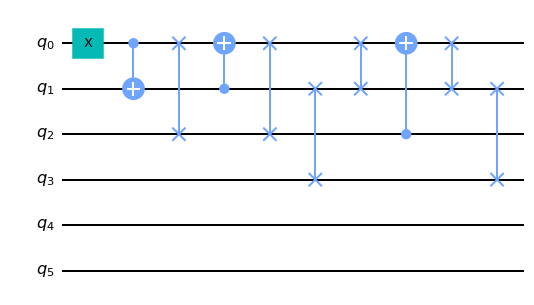

In [10]:
from qiskit import QuantumCircuit as qc

# 回路図を表示
qc.from_qasm_str(qasm).draw('mpl', plot_barriers=False)